# Analytics for Keyword Expansion

Let's imagine we are sitting in the marketing department of a company selling jewelry. We need to plan a campaign with some corner points:
- it should be running on Facebook Ads
- it should be approximately a month long
- we should spend ballpark 500 USD on it daily
- the ad creative is not perfectly set, but should be centered around the term "embrace your individuality"

Now, we have to find keywords to target the ad with.

In order to do that, we have past campaign data at our disposal. In this notebook the aim is to showcase how to drill through the data effectively to help our efforts finding the best keywords.

In [1]:
%pip install superlinked==8.8.1
%pip install matplotlib

In [2]:
import altair as alt
import os
import pandas as pd
from datetime import datetime, timedelta
import warnings

from superlinked.framework.common.dag.context import CONTEXT_COMMON, CONTEXT_COMMON_NOW
from superlinked.framework.common.dag.period_time import PeriodTime
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import (
    String,
    StringList,
    Timestamp,
    Integer,
    Float,
)
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
    InMemoryApp,
)
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.categorical_similarity_space import (
    CategoricalSimilaritySpace,
)
from superlinked.framework.dsl.space.number_space import NumberSpace, Mode
from superlinked.framework.dsl.space.recency_space import RecencySpace
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace

alt.data_transformers.disable_max_rows()
alt.renderers.enable("mimetype")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
# silence torch warning from sentence_transformers
warnings.filterwarnings(
    "ignore", category=UserWarning, message="TypedStorage is deprecated"
)

END_OF_2022_12_10_TS = int(datetime(2022, 12, 11).timestamp())
EXECUTOR_DATA = {CONTEXT_COMMON: {CONTEXT_COMMON_NOW: END_OF_2022_12_10_TS}}

In [3]:
def describe_with_percentiles(
    series: pd.Series,
    percentiles: list[float] = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995],
) -> pd.DataFrame:
    """
    Wrapper around pd.series.describe() giving the percentiles arg a different default.
    """
    return series.describe(percentiles=percentiles)

In [4]:
DATASET_URL: str = (
    "https://storage.googleapis.com/superlinked-notebook-analytics-keyword-expansion-ads/marketing-dataset-filtered.csv"
)
USE_COLUMNS: list[str] = [
    "time",
    "media_cost_usd",
    "no_of_days",
    "search_tags",
    "keywords",
    "ext_service_name",
    "clicks",
]

## Load and clean dataset

In [5]:
NROWS = os.getenv("NOTEBOOK_TEST_ROW_LIMIT", None)
NROWS = NROWS if NROWS is None else int(NROWS)
dataset = pd.read_csv(DATASET_URL, nrows=NROWS).reset_index()
dataset.head()

,index,campaign_item_id,no_of_days,time,ext_service_id,ext_service_name,creative_id,creative_width,creative_height,search_tags,template_id,landing_page,advertiser_id,advertiser_name,network_id,approved_budget,advertiser_currency,channel_id,channel_name,max_bid_cpm,network_margin,campaign_budget_usd,impressions,clicks,stats_currency,currency_code,exchange_rate,media_cost_usd,position_in_content,unique_reach,total_reach,search_tag_cat,cmi_currency_code,timezone,weekday_cat,keywords
0,0,2733,9,2022-05-03,128,Facebook Ads,1000,300.000,250.000,#Embrace Your Individuality with X,90.000,https://www.abcjewelry.com/collections/boho-je...,4756,Web,190,400.000,SGD,8,Social,NaN,0.000,652.174,2135,32,SGD,SGD,1,109.420,NaN,NaN,NaN,Others,SGD,Asia/Singapore,week_day,artisan jewelry
1,1,2766,54,2022-06-01,4,Google Ads,1005,0.000,0.000,#The Ultimate Fashion Statement with X,23.000,https://www.abcjewelry.com/collections/gemston...,5191,Brand,287,1000.000,USD,32,Mobile,1.000,0.000,760.000,876,18,USD,USD,1,43.151,NaN,NaN,NaN,Youtube,USD,America/New_York,week_day,bridal jewelry
2,2,2766,55,2022-06-02,16,DV360,1005,0.000,0.000,#The Ultimate Fashion Statement with X,23.000,https://www.abcjewelry.com/collections/stateme...,5191,Brand,287,1000.000,USD,1,Display,1.000,0.000,760.000,790,12,USD,USD,1,31.436,NaN,NaN,NaN,Youtube,USD,America/New_York,week_day,unique and trendy jewelry
3,3,2766,58,2022-06-05,128,Facebook Ads,1005,0.000,0.000,#Embrace Your Individuality with X,23.000,https://www.abcjewelry.com/collections/gemston...,5191,Brand,287,1000.000,USD,4,Search,1.000,0.000,760.000,655,12,USD,USD,1,13.351,NaN,NaN,NaN,Youtube,USD,America/New_York,week_end,artisan jewelry
4,4,2766,62,2022-06-09,128,Facebook Ads,1005,0.000,0.000,#Embrace Your Individuality with X,23.000,https://www.abcjewelry.com/collections/pendant...,5191,Brand,287,1000.000,USD,64,Video,1.000,0.000,760.000,622,10,USD,USD,1,13.629,NaN,NaN,NaN,Youtube,USD,America/New_York,week_day,rhinestone jewelry


In [6]:
filtered_dataset = dataset.loc[:, USE_COLUMNS].reset_index().copy()
# filtering for campaings with spending and days info\n",
filtered_dataset = filtered_dataset[filtered_dataset["no_of_days"] > 0]
filtered_dataset = filtered_dataset[filtered_dataset["media_cost_usd"] > 0]
# calculate and clena\n",
filtered_dataset["time"] = [
    int(f.timestamp()) for f in pd.to_datetime(filtered_dataset.loc[:, "time"])
]
filtered_dataset["daily_cost"] = (
    filtered_dataset.loc[:, "media_cost_usd"] / filtered_dataset.loc[:, "no_of_days"]
)
filtered_dataset["daily_click"] = (
    filtered_dataset.loc[:, "clicks"] / filtered_dataset.loc[:, "no_of_days"]
)
filtered_dataset["cost_per_click"] = (
    filtered_dataset.loc[:, "media_cost_usd"] / filtered_dataset.loc[:, "clicks"]
)
filtered_dataset.shape

(23886, 11)

In [7]:
# uncomment this line to run on a smaller sample of data for a quick run
# filtered_dataset = filtered_dataset.sample(2000)

## Data exploration

To find the right space parameters.

<Axes: >

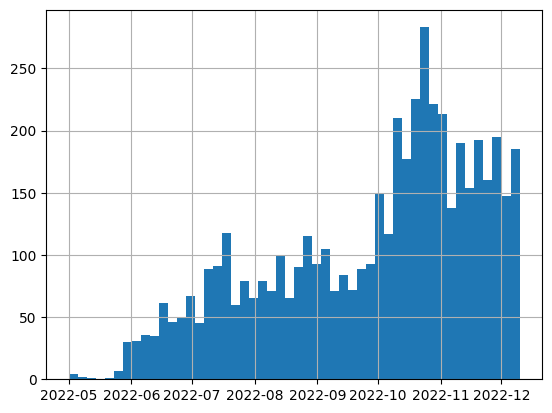

In [8]:
pd.to_datetime(filtered_dataset["time"], unit="s").hist(bins=50)

Recency space should have two period times - one for the frequent 2 months, and 8 months to cover the whole span of time campaings happened.

See other space parameters inline with the corresponding table creation.

In [9]:
# encode between [0-100] using NumberSpace with Similar mode as we might prefer varying campaign lengths based on our preferences
describe_with_percentiles(filtered_dataset["no_of_days"])

count   5000.000
mean      27.777
std       25.604
min        1.000
5%         2.000
10%        4.000
25%        9.000
50%       20.000
75%       38.000
90%       66.000
95%       86.000
99%      111.000
99.5%    115.000
max      118.000
Name: no_of_days, dtype: float64

In [10]:
# very skewed, depends on no_of_days, not embedding it!
describe_with_percentiles(filtered_dataset["clicks"])

count   5000.000
mean      55.224
std      386.766
min        2.000
5%         3.000
10%        3.000
25%        5.000
50%        8.000
75%       12.000
90%       75.000
95%      151.050
99%      754.020
99.5%   1522.035
max     9762.000
Name: clicks, dtype: float64

In [11]:
# encode between [0, 50] outliers would skew the distribution. Use NumberSpace with Similar mode as we might have different budgets
describe_with_percentiles(filtered_dataset["daily_cost"])

count   5000.000
mean       2.186
std       25.727
min        0.000
5%         0.002
10%        0.005
25%        0.017
50%        0.080
75%        0.638
90%        3.253
95%        6.914
99%       32.557
99.5%     48.853
max     1695.630
Name: daily_cost, dtype: float64

In [12]:
# encode between [0, 100] outliers would skew the distribution. Use NumberSpace with Maximum Mode as we prefer better daily_click bringing campaigns all else being equal
describe_with_percentiles(filtered_dataset["daily_click"])

count   5000.000
mean       7.843
std       76.552
min        0.017
5%         0.064
10%        0.090
25%        0.172
50%        0.400
75%        1.545
90%        9.357
95%       22.000
99%      131.932
99.5%    261.217
max     4285.000
Name: daily_click, dtype: float64

In [13]:
# encode between [0, 2] outliers would skew the distribution. Use NumberSpace with Minimum Mode as we prefer campaigns that achieve a click spending less dollars. Measured in thousand USD.
describe_with_percentiles(filtered_dataset["cost_per_click"])

count   5000.000
mean       0.403
std        0.677
min        0.000
5%         0.011
10%        0.022
25%        0.069
50%        0.199
75%        0.446
90%        0.976
95%        1.459
99%        3.341
99.5%      4.050
max       11.064
Name: cost_per_click, dtype: float64

In [14]:
# low cardinality categorical variable, let's use CategoricalSimilaritySpace!
filtered_dataset["ext_service_name"].value_counts()

ext_service_name
Google Ads      1710
DV360           1645
Facebook Ads    1645
Name: count, dtype: int64

In [15]:
filtered_dataset.head()

,index,time,media_cost_usd,no_of_days,search_tags,keywords,ext_service_name,clicks,daily_cost,daily_click,cost_per_click
22435,22435,1667001600,3.118,8,#Embrace Your Individuality with X,art nouveau jewelry,Google Ads,2,0.390,0.250,1.559
7907,7907,1667520000,0.208,18,#The Ultimate Fashion Statement with X,bangles,Google Ads,6,0.012,0.333,0.035
21867,21867,1667260800,0.163,11,#Embrace Your Individuality with X,costume jewelry sets,DV360,3,0.015,0.273,0.054
3334,3334,1666742400,0.440,33,#Embrace Your Individuality with X,fashionable jewelry,DV360,11,0.013,0.333,0.040
23191,23191,1655337600,42.363,55,#Embrace Your Individuality with X,seashell jewelry,Google Ads,153,0.770,2.782,0.277


## Set up Superlinked

In [16]:
@schema
class Campaign:
    id: IdField
    start_date: Timestamp
    number_of_days: Integer
    creative: String
    keywords: String
    ext_service_name: StringList
    daily_cost: Float
    daily_click: Float
    cost_per_click: Float

In [17]:
campaign = Campaign()

In [18]:
# use parameters derived above from plots and tables
recency_space = RecencySpace(
    timestamp=campaign.start_date,
    period_time_list=[PeriodTime(timedelta(days=60)), PeriodTime(timedelta(days=180))],
)
num_days_space = NumberSpace(
    number=campaign.number_of_days, min_value=1, max_value=100, mode=Mode.SIMILAR
)
daily_cost_space = NumberSpace(
    number=campaign.daily_cost, min_value=0, max_value=50, mode=Mode.SIMILAR
)
daily_click_space = NumberSpace(
    number=campaign.daily_click, min_value=0, max_value=100, mode=Mode.MAXIMUM
)
cost_per_click_space = NumberSpace(
    number=campaign.daily_click, min_value=0, max_value=2, mode=Mode.MINIMUM
)
service_space = CategoricalSimilaritySpace(
    category_input=campaign.ext_service_name,
    categories=filtered_dataset["ext_service_name"].unique().tolist(),
    negative_filter=-5.0,
)
# textual data is simply encoded using a reasonably large and well performing model
creative_space = TextSimilaritySpace(
    text=campaign.creative, model="sentence-transformers/all-mpnet-base-v2"
)
keywords_space = TextSimilaritySpace(
    text=campaign.keywords, model="sentence-transformers/all-mpnet-base-v2"
)

In [19]:
campaign_index = Index(
    spaces=[
        recency_space,
        num_days_space,
        daily_cost_space,
        daily_click_space,
        cost_per_click_space,
        service_space,
        creative_space,
        keywords_space,
    ]
)

In [20]:
campaign_df_parser = DataFrameParser(
    schema=campaign,
    mapping={
        campaign.id: "index",
        campaign.start_date: "time",
        campaign.number_of_days: "no_of_days",
        campaign.creative: "search_tags",
    },
)

In [21]:
source_campaign: InMemorySource = InMemorySource(campaign, parser=campaign_df_parser)
executor: InMemoryExecutor = InMemoryExecutor(
    sources=[source_campaign], indices=[campaign_index], context_data=EXECUTOR_DATA
)
app: InMemoryApp = executor.run()

In [22]:
source_campaign.put([filtered_dataset])

## Run queries

In [23]:
# a query to browse campaign data without taking a specific campaign as base
# define a versatile query and simply just switch in features as we go
campaign_discovery_query = (
    Query(
        campaign_index,
        weights={
            keywords_space: Param("keywords_weight"),
            creative_space: Param("creative_weight"),
            service_space: Param("service_weight"),
            cost_per_click_space: Param("cost_per_click_weight"),
            daily_cost_space: Param("daily_cost_weight"),
            daily_click_space: Param("daily_click_weight"),
            num_days_space: Param("num_days_weight"),
            recency_space: Param("recency_weight"),
        },
    )
    .find(campaign)
    .similar(num_days_space.number, Param("target_length_in_days"))
    .similar(daily_cost_space.number, Param("target_daily_cost"))
    .similar(creative_space.text, Param("target_creative"))
    .similar(keywords_space.text, Param("target_keywords"))
    .similar(service_space.category, Param("target_service"))
    .limit(Param("limit"))
)

In [24]:
def parse_timestamp_in_result(result) -> pd.DataFrame:
    """Thin wrapper to get dates instead of timestamps."""
    result_df = result.to_pandas()
    result_df["start_date"] = [
        datetime.fromtimestamp(f).date() for f in result_df["start_date"]
    ]
    return result_df

In [25]:
# first let's just switch the search on in terms of the text of the creative of the ad
only_search_tag_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=0,
    cost_per_click_weight=0,
    daily_cost_weight=0,
    daily_click_weight=0,
    num_days_weight=0,
    recency_weight=0,
    target_length_in_days=0.0,
    target_daily_cost=0,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="",
    limit=10,
)

# these are essentially in random order, as there are only 2 distinct creatives at the moment
parse_timestamp_in_result(only_search_tag_results)

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id
0,2022-10-29,8,#Embrace Your Individuality with X,art nouveau jewelry,Google Ads,0.390,0.250,1.559,22435
1,2022-11-01,11,#Embrace Your Individuality with X,costume jewelry sets,DV360,0.015,0.273,0.054,21867
2,2022-10-26,33,#Embrace Your Individuality with X,fashionable jewelry,DV360,0.013,0.333,0.040,3334
3,2022-06-16,55,#Embrace Your Individuality with X,seashell jewelry,Google Ads,0.770,2.782,0.277,23191
4,2022-12-05,52,#Embrace Your Individuality with X,tribal jewelry,Facebook Ads,0.005,0.154,0.029,11218
5,2022-12-07,51,#Embrace Your Individuality with X,whimsical jewelry,DV360,0.012,0.118,0.100,11039
6,2022-09-24,1,#Embrace Your Individuality with X,multi-strand necklaces,DV360,3.163,10.000,0.316,20785
7,2022-11-27,44,#Embrace Your Individuality with X,minimalist jewelry,Facebook Ads,0.009,0.159,0.055,19156
8,2022-08-23,7,#Embrace Your Individuality with X,hair accessories,Facebook Ads,0.275,1.571,0.175,21257
9,2022-10-16,23,#Embrace Your Individuality with X,seashell jewelry,DV360,0.002,0.348,0.006,4333


In [26]:
# now let's only consider campaigns on Facebook
search_tag_on_fb_result = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=0,
    daily_cost_weight=0,
    daily_click_weight=0,
    num_days_weight=0,
    recency_weight=0,
    target_length_in_days=0,
    target_daily_cost=0,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

parse_timestamp_in_result(search_tag_on_fb_result)

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id
0,2022-12-05,52,#Embrace Your Individuality with X,tribal jewelry,Facebook Ads,0.005,0.154,0.029,11218
1,2022-11-27,44,#Embrace Your Individuality with X,minimalist jewelry,Facebook Ads,0.009,0.159,0.055,19156
2,2022-08-23,7,#Embrace Your Individuality with X,hair accessories,Facebook Ads,0.275,1.571,0.175,21257
3,2022-10-25,8,#Embrace Your Individuality with X,initial jewelry,Facebook Ads,0.040,1.000,0.040,15059
4,2022-12-07,47,#Embrace Your Individuality with X,affordable trendy jewelry,Facebook Ads,0.035,0.191,0.182,10037
5,2022-10-09,16,#Embrace Your Individuality with X,formal jewelry,Facebook Ads,0.003,0.375,0.007,17761
6,2022-11-27,41,#Embrace Your Individuality with X,winter jewelry,Facebook Ads,0.056,0.171,0.328,11076
7,2022-09-27,4,#Embrace Your Individuality with X,statement necklaces,Facebook Ads,0.040,2.500,0.016,21365
8,2022-11-03,49,#Embrace Your Individuality with X,mixed metal jewelry,Facebook Ads,0.033,0.143,0.230,2660
9,2022-10-14,7,#Embrace Your Individuality with X,nature-inspired jewelry,Facebook Ads,0.081,0.857,0.095,21135


In [27]:
# now let's take into account that we are looking for ~30 day campaigns
search_tag_fb_30_days_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=0,
    daily_cost_weight=0,
    daily_click_weight=0,
    num_days_weight=1,
    recency_weight=0,
    target_length_in_days=30.0,
    target_daily_cost=0,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

parse_timestamp_in_result(search_tag_fb_30_days_results)

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id
0,2022-11-20,30,#Embrace Your Individuality with X,zodiac jewelry,Facebook Ads,0.004,0.267,0.014,22538
1,2022-10-23,30,#Embrace Your Individuality with X,costume jewelry sets,Facebook Ads,0.079,0.233,0.337,21715
2,2022-11-20,30,#Embrace Your Individuality with X,body piercings,Facebook Ads,0.037,0.333,0.111,22216
3,2022-11-20,30,#Embrace Your Individuality with X,holiday jewelry,Facebook Ads,0.018,0.300,0.060,16234
4,2022-10-23,30,#Embrace Your Individuality with X,long necklaces,Facebook Ads,0.009,0.100,0.086,3534
5,2022-11-17,30,#Embrace Your Individuality with X,dazzling jewelry,Facebook Ads,0.007,0.333,0.022,22567
6,2022-11-16,30,#Embrace Your Individuality with X,chic jewelry,Facebook Ads,0.010,0.233,0.043,19304
7,2022-10-22,30,#Embrace Your Individuality with X,tribal jewelry,Facebook Ads,0.064,0.333,0.192,4977
8,2022-11-14,31,#Embrace Your Individuality with X,elegant jewelry,Facebook Ads,0.079,0.194,0.408,8137
9,2022-11-14,31,#Embrace Your Individuality with X,affordable jewelry,Facebook Ads,0.017,0.097,0.175,19907


In [28]:
# let's also factor in that we aim to spend 0.5 thousand USDs a day
search_tag_fb_30_days_daily_05_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=0,
    daily_cost_weight=1,
    daily_click_weight=0,
    num_days_weight=1,
    recency_weight=0,
    target_length_in_days=30.0,
    target_daily_cost=0.5,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

# some extremely low spending campaings now disappeared from the top results
parse_timestamp_in_result(search_tag_fb_30_days_daily_05_results)

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id
0,2022-10-23,30,#Embrace Your Individuality with X,costume jewelry sets,Facebook Ads,0.079,0.233,0.337,21715
1,2022-10-22,30,#Embrace Your Individuality with X,tribal jewelry,Facebook Ads,0.064,0.333,0.192,4977
2,2022-11-20,30,#Embrace Your Individuality with X,body piercings,Facebook Ads,0.037,0.333,0.111,22216
3,2022-11-20,30,#Embrace Your Individuality with X,holiday jewelry,Facebook Ads,0.018,0.300,0.060,16234
4,2022-11-16,30,#Embrace Your Individuality with X,chic jewelry,Facebook Ads,0.010,0.233,0.043,19304
5,2022-10-23,30,#Embrace Your Individuality with X,long necklaces,Facebook Ads,0.009,0.100,0.086,3534
6,2022-11-17,30,#Embrace Your Individuality with X,dazzling jewelry,Facebook Ads,0.007,0.333,0.022,22567
7,2022-11-20,30,#Embrace Your Individuality with X,zodiac jewelry,Facebook Ads,0.004,0.267,0.014,22538
8,2022-10-15,29,#Embrace Your Individuality with X,artisanal jewelry,Facebook Ads,0.612,0.414,1.479,14632
9,2022-09-30,31,#Embrace Your Individuality with X,layered bracelets,Facebook Ads,0.366,0.355,1.033,12245


### Optimise for a target

Now let's also blend in that we are looking for the best campaigns within these soft filters

#### Clicks

In [29]:
# get the most clicks without regard to cost
search_click_optim_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=0,
    daily_cost_weight=1,
    daily_click_weight=0.1,
    num_days_weight=1,
    recency_weight=0,
    target_length_in_days=30.0,
    target_daily_cost=0.5,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

# high click creating campaigns are at the top - regardless of their cost
parse_timestamp_in_result(search_click_optim_results)

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id
0,2022-08-30,25,#Embrace Your Individuality with X,animal jewelry,Facebook Ads,3.945,342.040,0.012,23932
1,2022-09-02,15,#Embrace Your Individuality with X,everyday jewelry,Facebook Ads,4.927,425.333,0.012,23951
2,2022-08-31,13,#Embrace Your Individuality with X,casual jewelry,Facebook Ads,3.030,117.615,0.026,24266
3,2022-08-29,11,#Embrace Your Individuality with X,modern jewelry,Facebook Ads,6.700,170.818,0.039,23949
4,2022-09-03,16,#Embrace Your Individuality with X,concert jewelry,Facebook Ads,3.480,58.562,0.059,23463
5,2022-10-13,15,#Embrace Your Individuality with X,drop earrings,Facebook Ads,7.933,64.067,0.124,6775
6,2022-10-19,21,#Embrace Your Individuality with X,retro jewelry,Facebook Ads,2.426,18.381,0.132,6564
7,2022-09-08,21,#Embrace Your Individuality with X,costume jewelry sets,Facebook Ads,1.871,17.238,0.109,7494
8,2022-06-08,26,#Embrace Your Individuality with X,minimalist jewelry,Facebook Ads,0.785,7.269,0.108,23272
9,2022-08-19,27,#Embrace Your Individuality with X,midi rings,Facebook Ads,2.120,6.778,0.313,7040


In [30]:
# take it to the extreme - be more lenient with daily_cost and no_of_days thresholds and favor better performing campaigns
extreme_search_click_optim_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=0,
    daily_cost_weight=1,
    daily_click_weight=1,
    num_days_weight=1,
    recency_weight=0,
    target_length_in_days=30.0,
    target_daily_cost=0.5,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

# the results focus even more on the clicks the campaign was able to generate
parse_timestamp_in_result(extreme_search_click_optim_results)

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id
0,2022-08-30,25,#Embrace Your Individuality with X,animal jewelry,Facebook Ads,3.945,342.040,0.012,23932
1,2022-09-02,15,#Embrace Your Individuality with X,everyday jewelry,Facebook Ads,4.927,425.333,0.012,23951
2,2022-08-31,13,#Embrace Your Individuality with X,casual jewelry,Facebook Ads,3.030,117.615,0.026,24266
3,2022-08-29,11,#Embrace Your Individuality with X,modern jewelry,Facebook Ads,6.700,170.818,0.039,23949
4,2022-09-03,10,#Embrace Your Individuality with X,fall jewelry,Facebook Ads,18.030,242.900,0.074,5761
5,2022-09-30,2,#Embrace Your Individuality with X,huggie earrings,Facebook Ads,15.227,111.500,0.137,6498
6,2022-08-07,2,#Embrace Your Individuality with X,beach jewelry,Facebook Ads,17.080,96.500,0.177,5836
7,2022-11-19,2,#Embrace Your Individuality with X,threader earrings,Facebook Ads,20.793,94.500,0.220,24406
8,2022-07-24,1,#Embrace Your Individuality with X,statement jewelry,Facebook Ads,25.331,107.000,0.237,24223
9,2022-10-13,15,#Embrace Your Individuality with X,drop earrings,Facebook Ads,7.933,64.067,0.124,6775


#### Cost

In [31]:
# Find the most efficient campaigns in terms of cost_per_click
search_cost_optim_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=1,
    daily_cost_weight=1,
    daily_click_weight=0,
    num_days_weight=1,
    recency_weight=0,
    target_length_in_days=30.0,
    target_daily_cost=0.5,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

parse_timestamp_in_result(search_cost_optim_results)

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id
0,2022-11-20,34,#Embrace Your Individuality with X,minimalistic jewelry,Facebook Ads,0.009,0.059,0.147,15017
1,2022-10-26,33,#Embrace Your Individuality with X,body piercings,Facebook Ads,0.000,0.061,0.005,17595
2,2022-10-28,35,#Embrace Your Individuality with X,affordable jewelry,Facebook Ads,0.013,0.057,0.236,21589
3,2022-07-22,32,#Embrace Your Individuality with X,hoop earrings,Facebook Ads,0.005,0.062,0.074,20962
4,2022-11-26,36,#Embrace Your Individuality with X,statement rings,Facebook Ads,0.035,0.056,0.633,16631
5,2022-11-21,31,#Embrace Your Individuality with X,formal jewelry,Facebook Ads,0.006,0.065,0.097,10066
6,2022-10-31,38,#Embrace Your Individuality with X,whimsical jewelry,Facebook Ads,0.021,0.053,0.402,9104
7,2022-10-22,29,#Embrace Your Individuality with X,seashell jewelry,Facebook Ads,0.001,0.069,0.009,3653
8,2022-11-11,28,#Embrace Your Individuality with X,retro jewelry,Facebook Ads,0.002,0.071,0.028,22773
9,2022-10-20,27,#Embrace Your Individuality with X,exquisite jewelry,Facebook Ads,0.084,0.074,1.137,9125


## What we achieved

Using Superlinked we were able to drill through our campaign dataset by gradually building up a collection of result sets where we are

1. softly favoring campaigns that are similar to our planned one in terms of:
    * length,
    * budget,
    * the ad platform we are targeting and
    * creative text.
<br/><br/>
2. optimize for different metrics having fine-grained control over the tradeoff of relaxing our constraints, but getting better performing campaigns.